In [33]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np
import re
import seaborn as sns
import matplotlib.patches as mpatches

In [34]:
# Utility functions

def filenames_from_cat(top,second):
    cats_globs = glob.glob('./*/*/*.cats')
    matches = []
    for g in cats_globs:
        with open(g) as file:
            for line in file:
                line = line.split()[0]
                line = line.split(",")
                if int(line[0]) == top and int(line[1]) == second:
                    dir = os.path.basename(g)
                    filename = os.path.splitext(dir)[0]
                    matches.append(filename)
    
    return matches

def print_email_from_filename(filename):
    full_filename = glob.glob('./*/*/' + str(filename) + '.txt')
    with open(full_filename[0]) as file:
        for line in file:
            print(line)

def save_email_from_filename(filename):
    full_filename = glob.glob('./*/*/' + str(filename) + '.txt')
    email_contents = ""
    with open(full_filename[0]) as file:
        for line in file:
            email_contents = email_contents + line
    return email_contents

def save_all_from_cat(primary, secondary):
    filenames = filenames_from_cat(primary, secondary)
    contents = ""
    for file in filenames:
        contents = contents + save_email_from_filename(file)
        contents = contents + "\n" + ("*" * 100) + "\n\n"
    return contents

def list_all_filenames():
    globs = glob.glob('./*/*/*.cats')
    filenames = []
    for file in globs:
        filenames.append(os.path.splitext(os.path.basename(file))[0])
    return filenames

def length_of_email_from_filename(filename):
    email_text = save_email_from_filename(filename)
    tokenised = word_tokenize(email_text)
    return len(tokenised)

def number_of_recipients(filename):
    addresses = []
    contents = save_email_from_filename(filename)
    contents = contents.split("\n")
    for line in contents:
        if line.startswith("To:"):
            addresses.append(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line))
    
    return len([j for sub in addresses for j in sub])

def get_sender_from_filename(filename):
    addresses = []
    contents = save_email_from_filename(filename)
    contents = contents.split("\n")
    for line in contents:
        if line.startswith("From:"):
            addresses.append(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", line))
    
    return [j for sub in addresses for j in sub][0]

In [35]:
# Partition emails into sensitive and non-sensitive
sensitive_filenames = []
# Assume 'Purely personal' and 'Personal but in a professional context' are the sensitive categories
sensitive_filenames.append(filenames_from_cat(1,2))
sensitive_filenames.append(filenames_from_cat(1,3))
# Flatten the list
sensitive_filenames = [j for sub in sensitive_filenames for j in sub]
# Remove duplicates - 3 emails are counted in both categories
sensitive_filenames = list(dict.fromkeys(sensitive_filenames))

non_sensitive_filenames = []
for name in list_all_filenames():
    if name not in sensitive_filenames:
        non_sensitive_filenames.append(name)

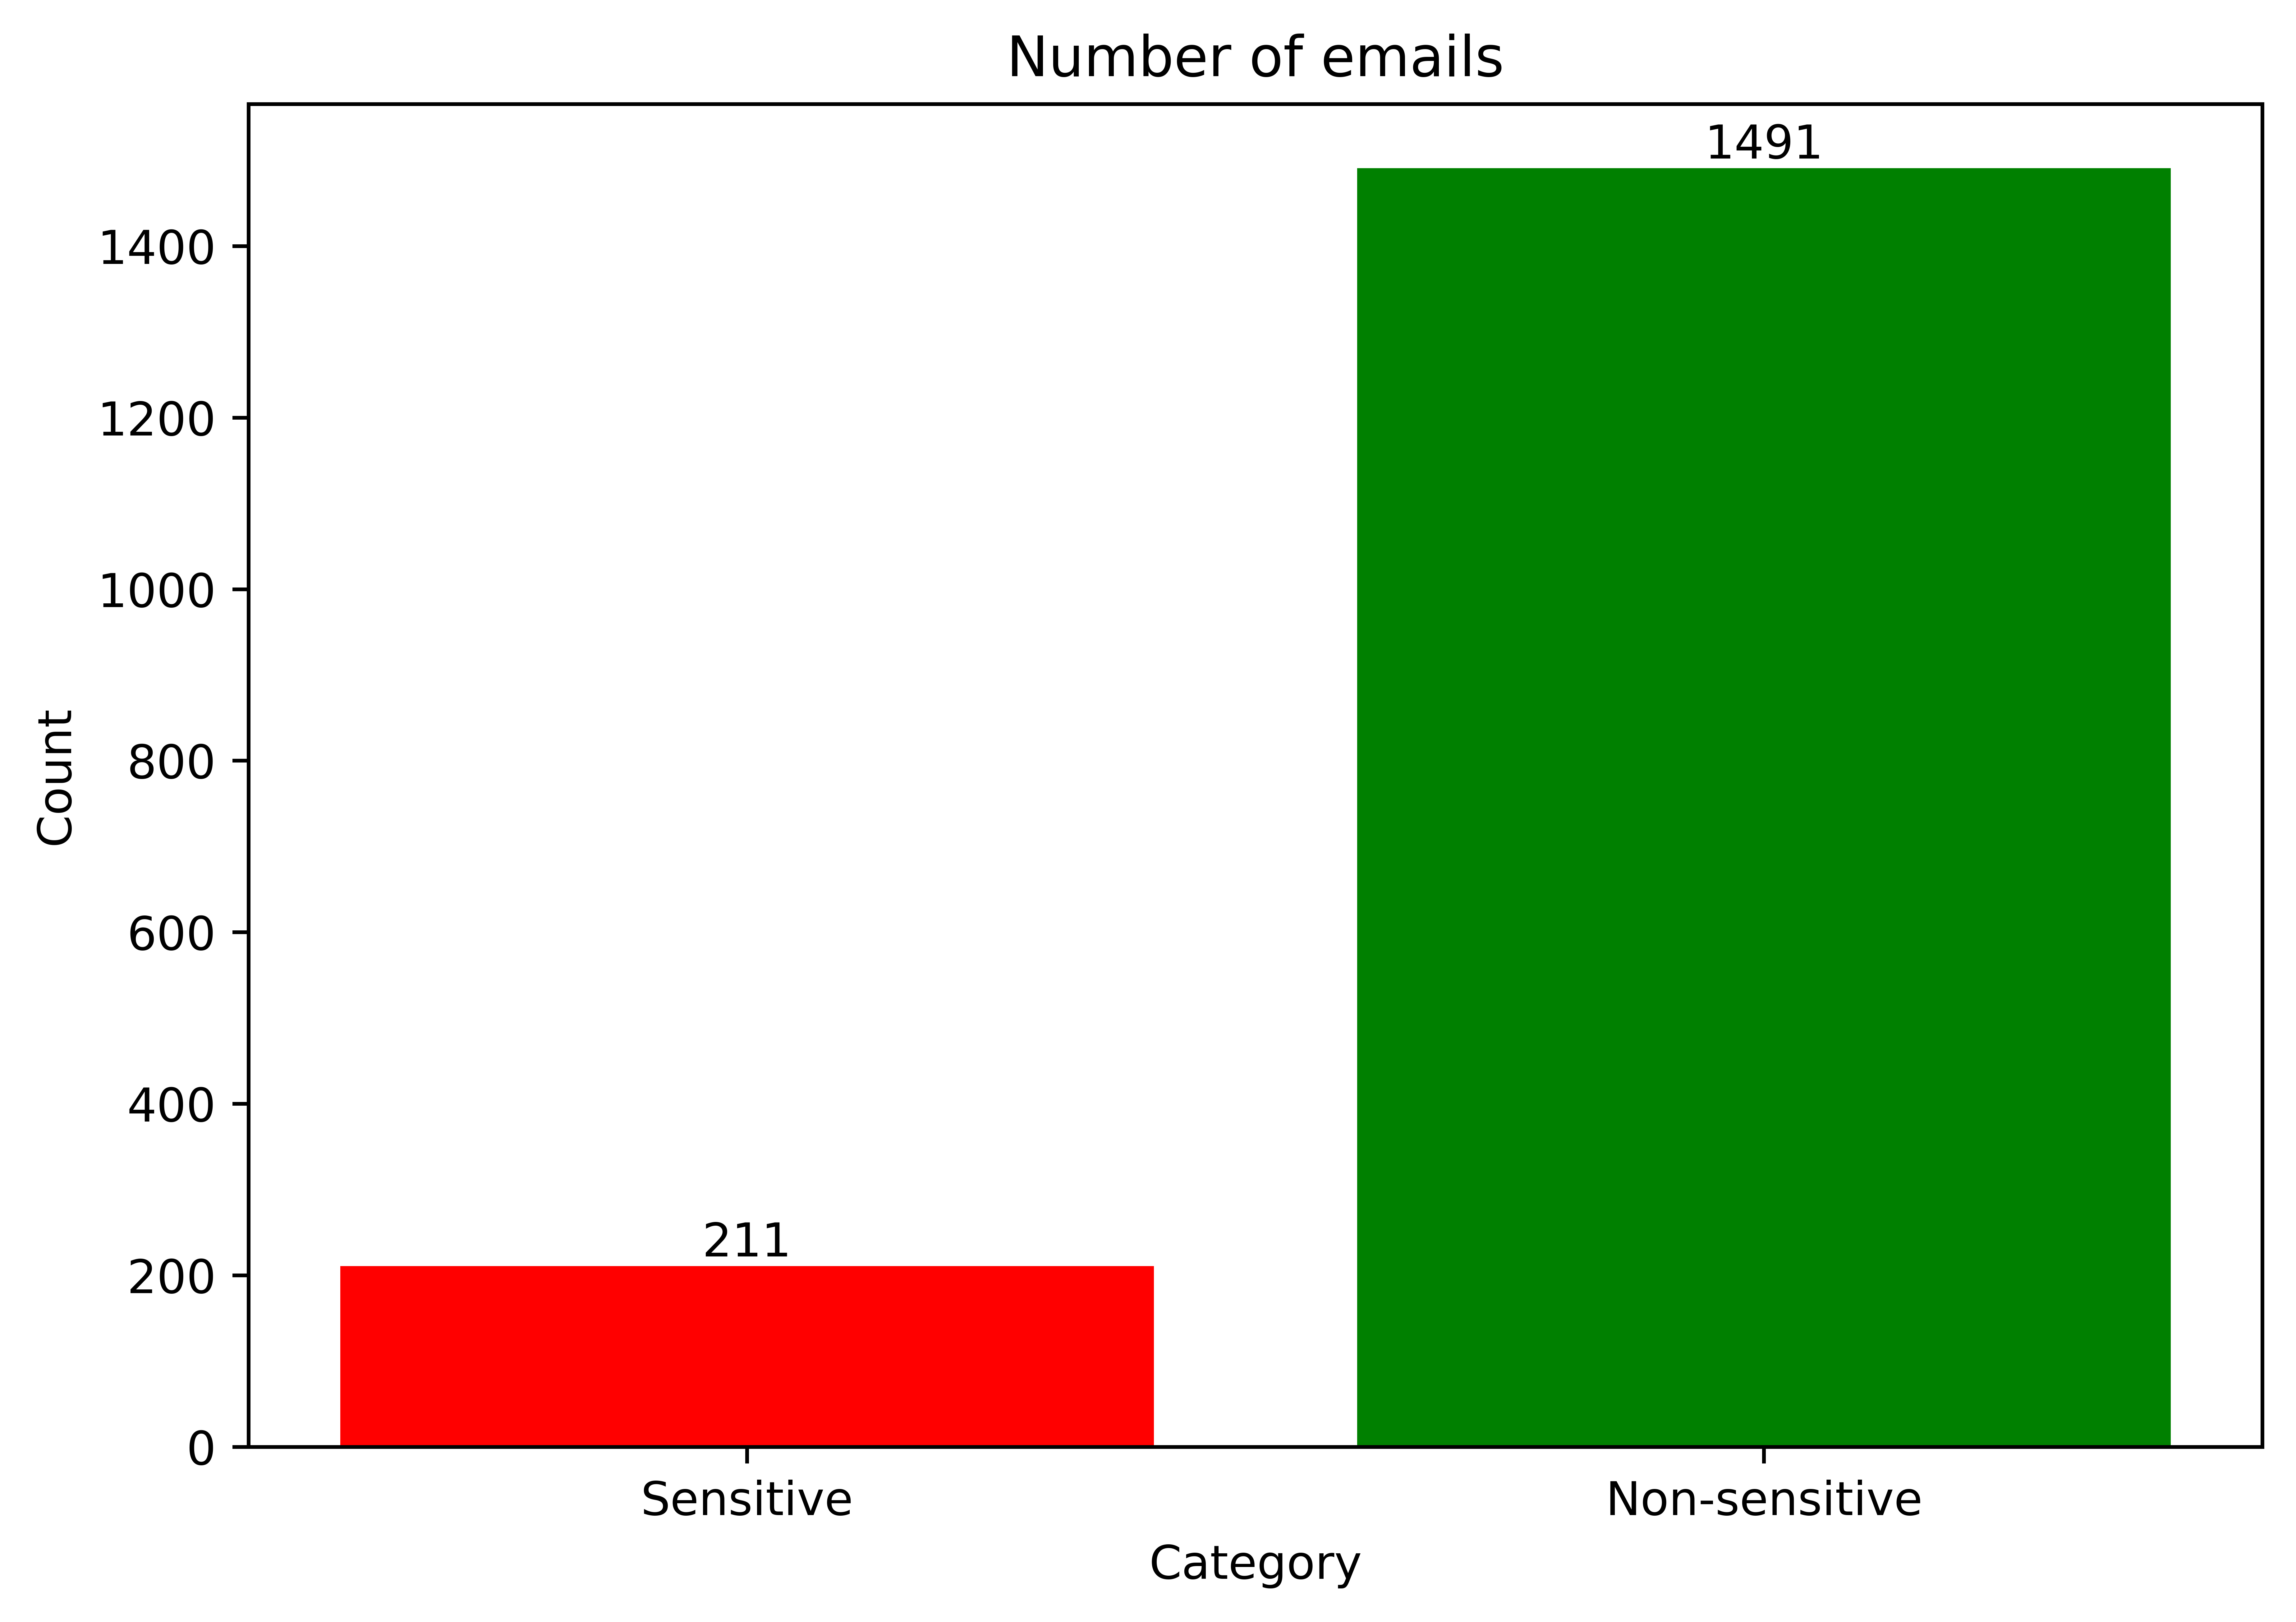

In [36]:
# Compare number of emails
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Sensitive", "Non-sensitive"]
data = [len(sensitive_filenames), len(non_sensitive_filenames)]
bars = ax.bar(labels,data, color = ["Red","Green"])
ax.set_title("Number of emails")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.bar_label(bars)
fig.set_dpi(1080)
plt.savefig('number_of_emails.png',bbox_inches='tight')

In [37]:
# Get lengths of sensitive vs non-sensitive emails

sensitive_lens = []
for name in sensitive_filenames:
    sensitive_lens.append(length_of_email_from_filename(name))

non_sensitive_lens = []
for name in non_sensitive_filenames:
    non_sensitive_lens.append(length_of_email_from_filename(name))

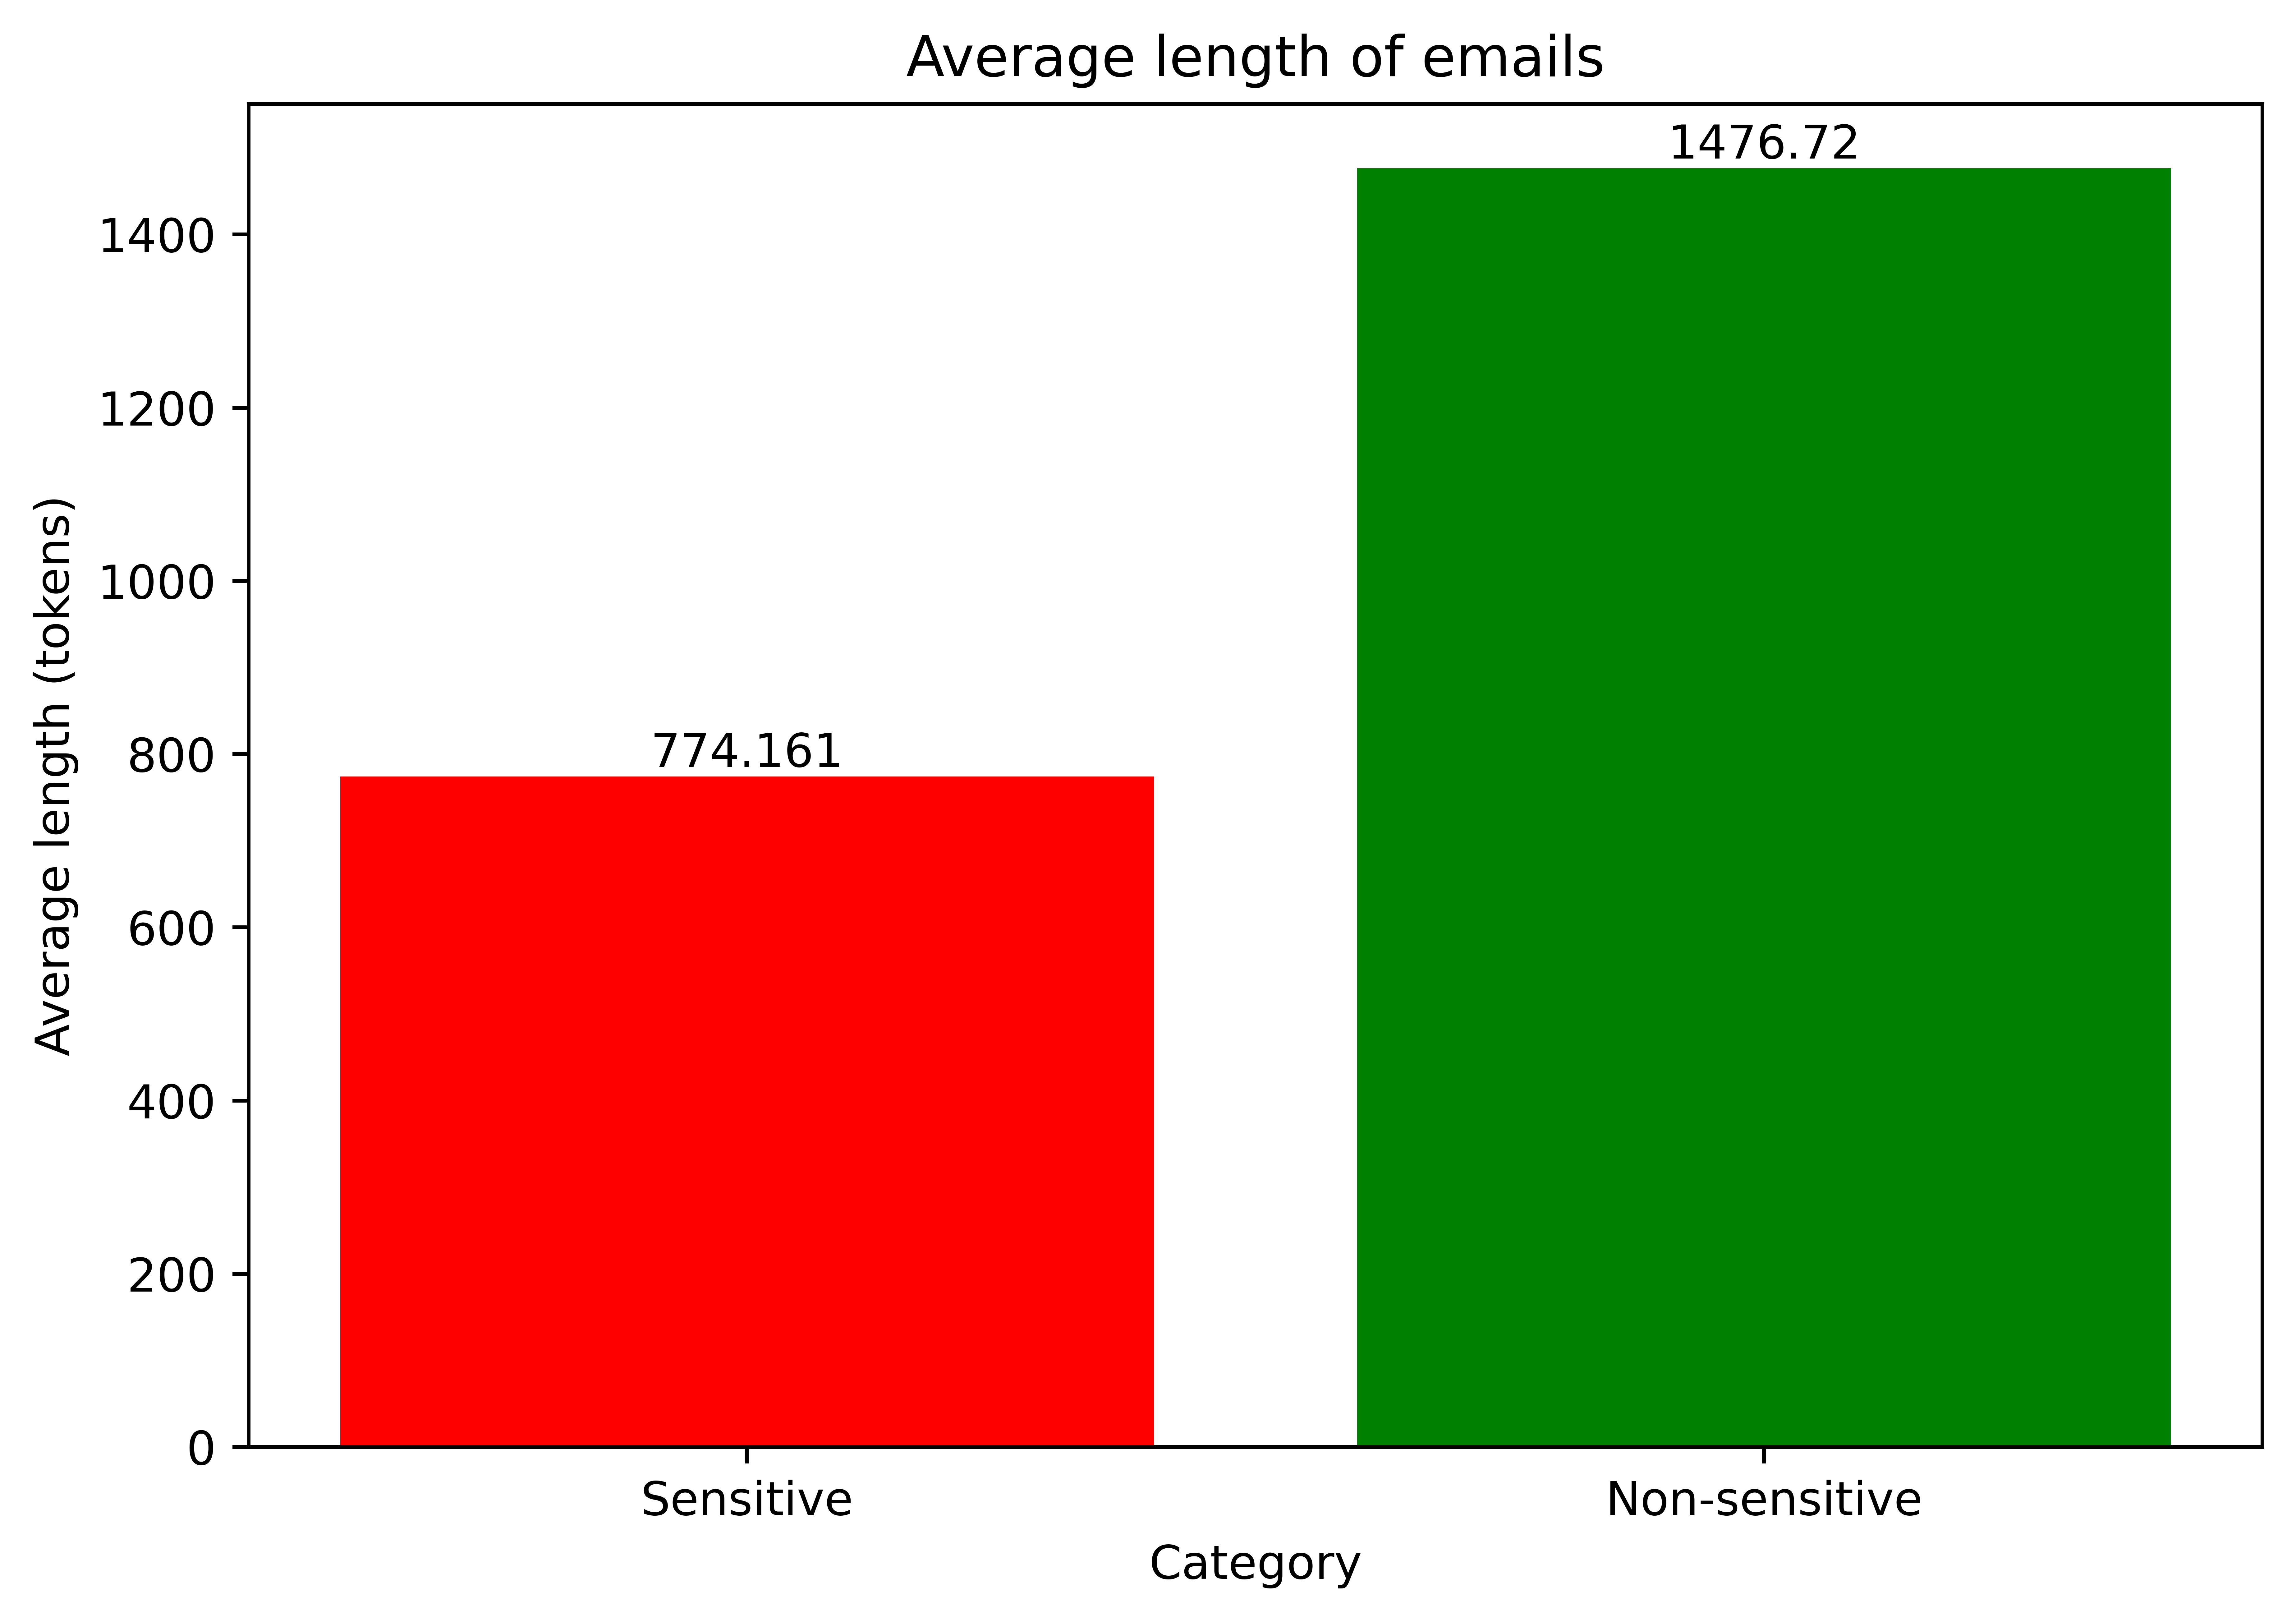

In [38]:
# Compare lengths of emails 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Sensitive", "Non-sensitive"]
data = [np.mean(sensitive_lens), np.mean(non_sensitive_lens)]
bars = ax.bar(labels,data, color = ["Red","Green"])
ax.set_title("Average length of emails")
ax.set_xlabel("Category")
ax.set_ylabel("Average length (tokens)")
ax.bar_label(bars)
fig.set_dpi(1080)
plt.savefig('length_of_emails_bar.png',bbox_inches='tight')

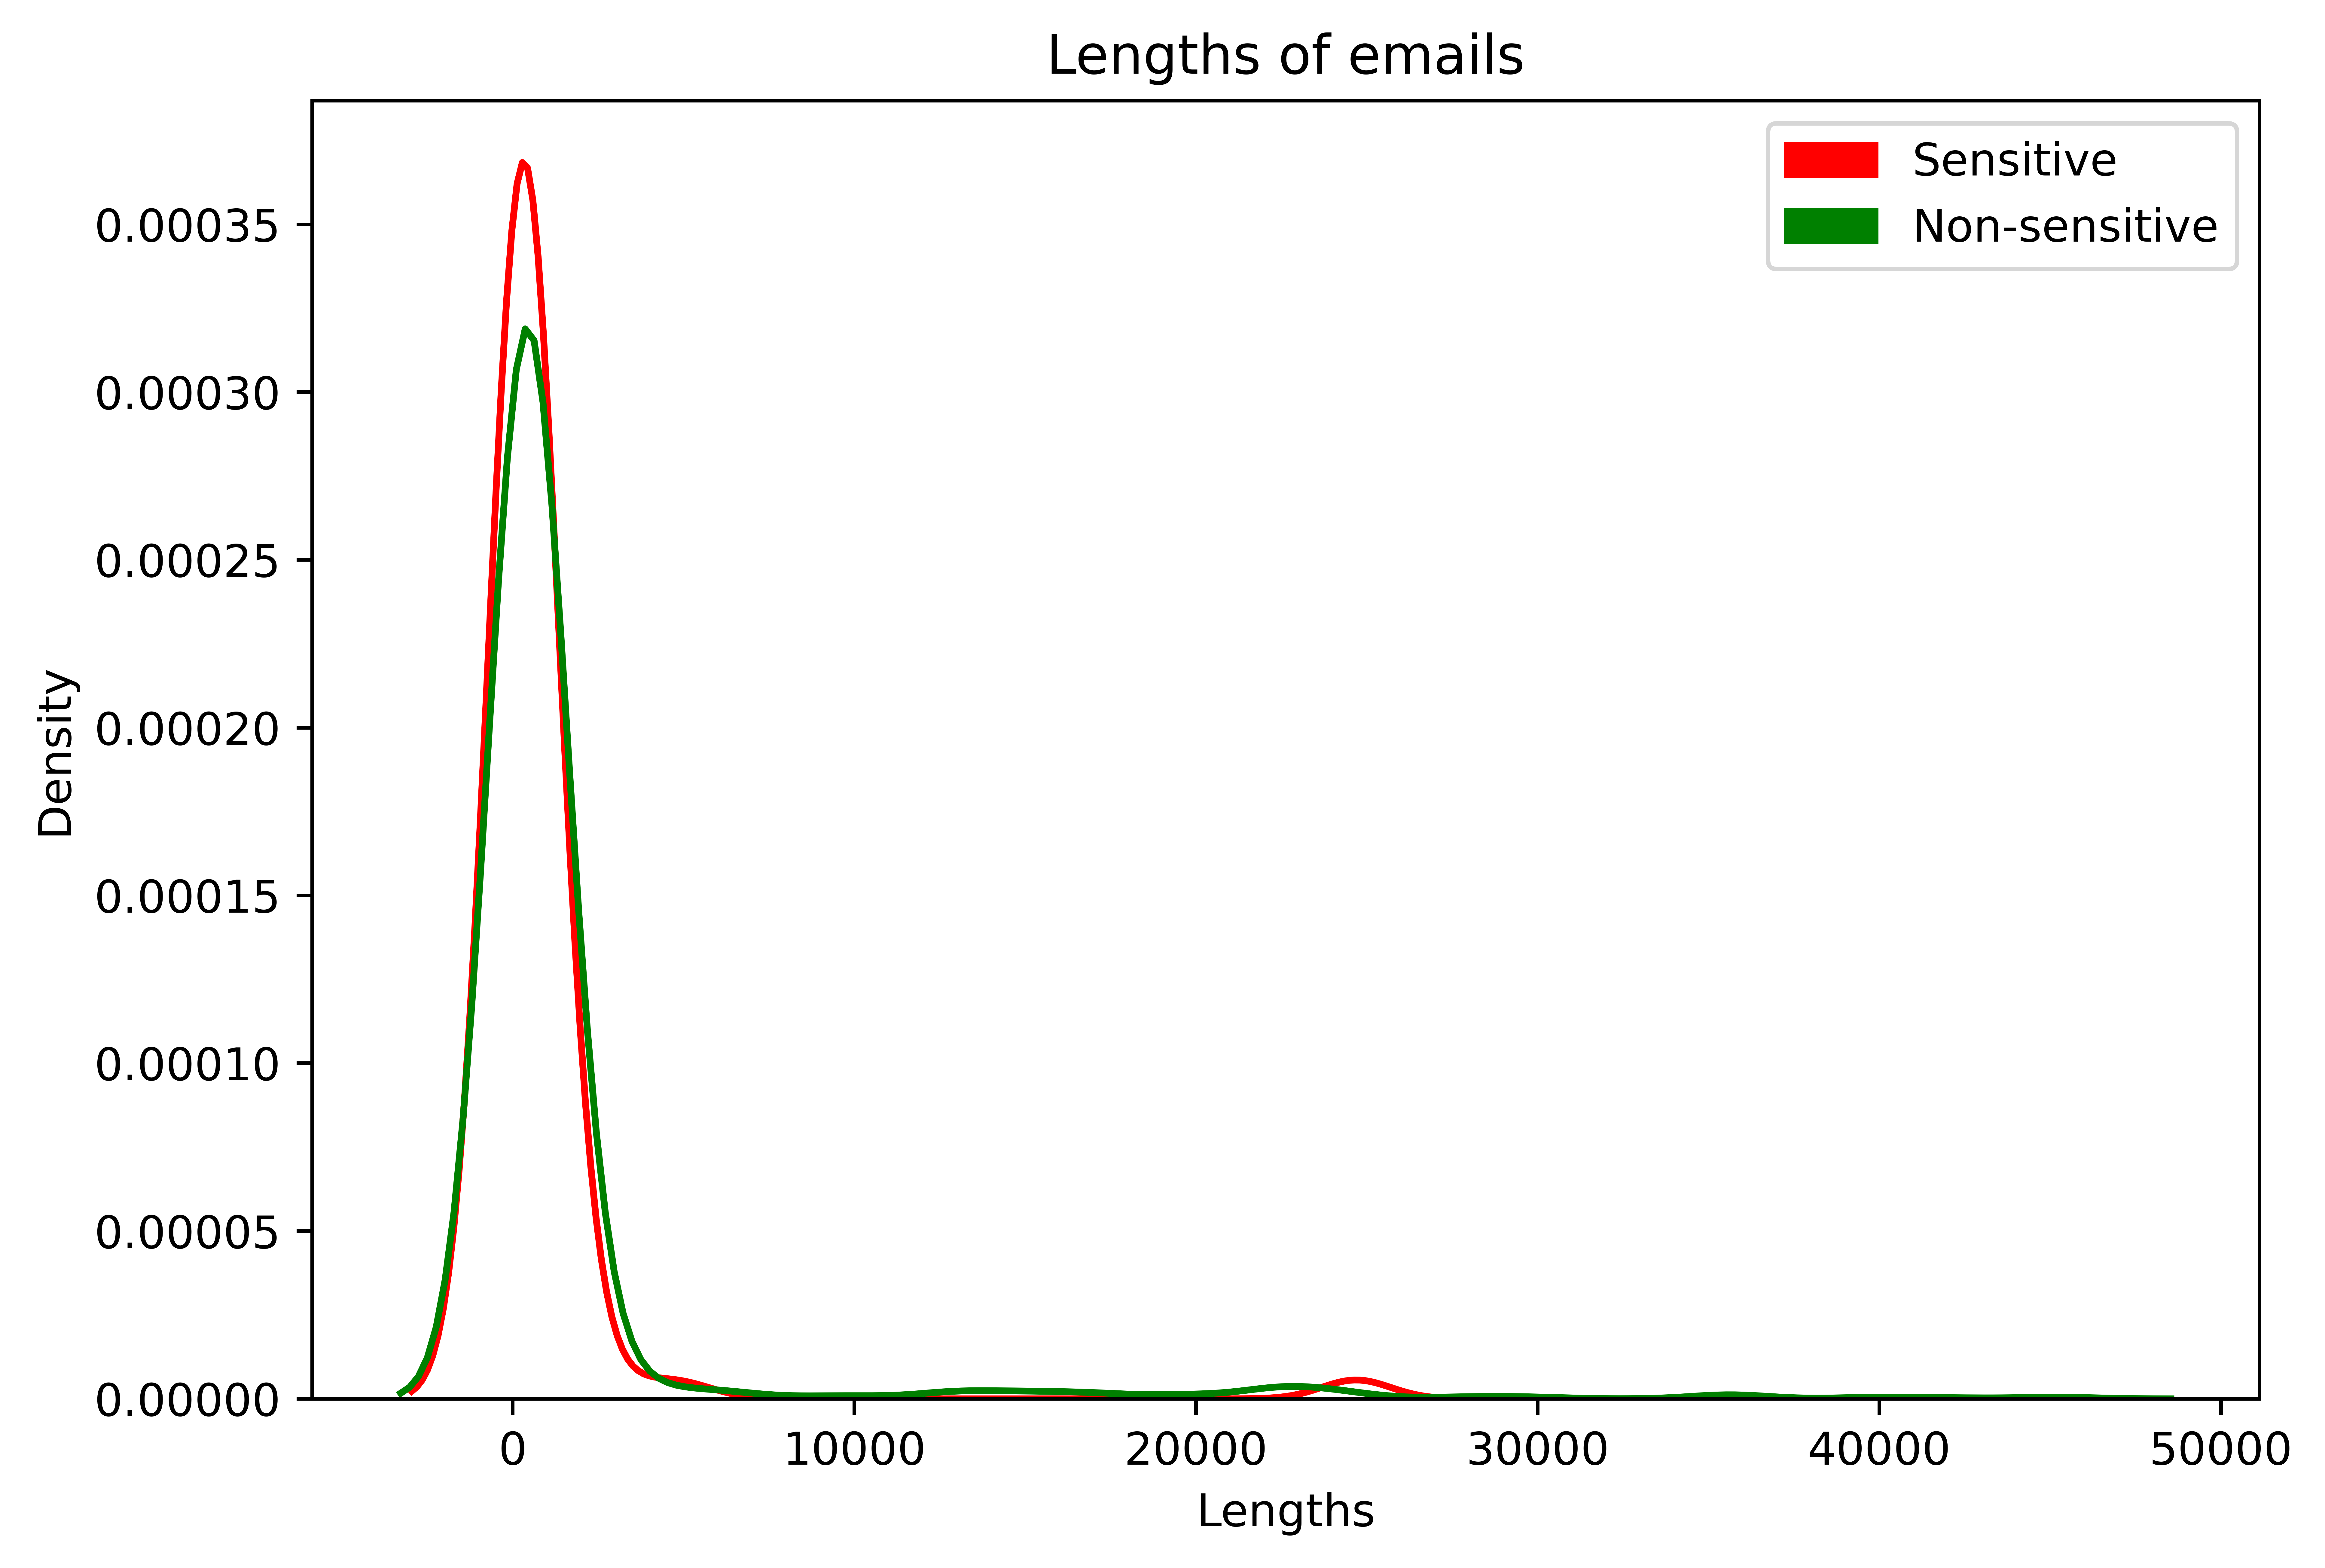

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.kdeplot(np.array(sensitive_lens),color="red",ax=ax)
sns.kdeplot(np.array(non_sensitive_lens),color="green",ax=ax)
ax.set_title("Lengths of emails")
ax.set_xlabel("Lengths")
ax.set_ylabel("Density")
sensitive_patch = mpatches.Patch(color='red', label='Sensitive')
non_sensitive_patch = mpatches.Patch(color='green', label='Non-sensitive')
plt.legend(loc="upper right",handles=[sensitive_patch, non_sensitive_patch])
fig.set_dpi(1080)
plt.savefig('length_of_emails_distribution.png',bbox_inches='tight')

In [40]:
# Get number of recipients of emails

sensitive_recipients = []
for name in sensitive_filenames:
    sensitive_recipients.append(number_of_recipients(name))

non_sensitive_recipients = []
for name in non_sensitive_filenames:
    non_sensitive_recipients.append(number_of_recipients(name))

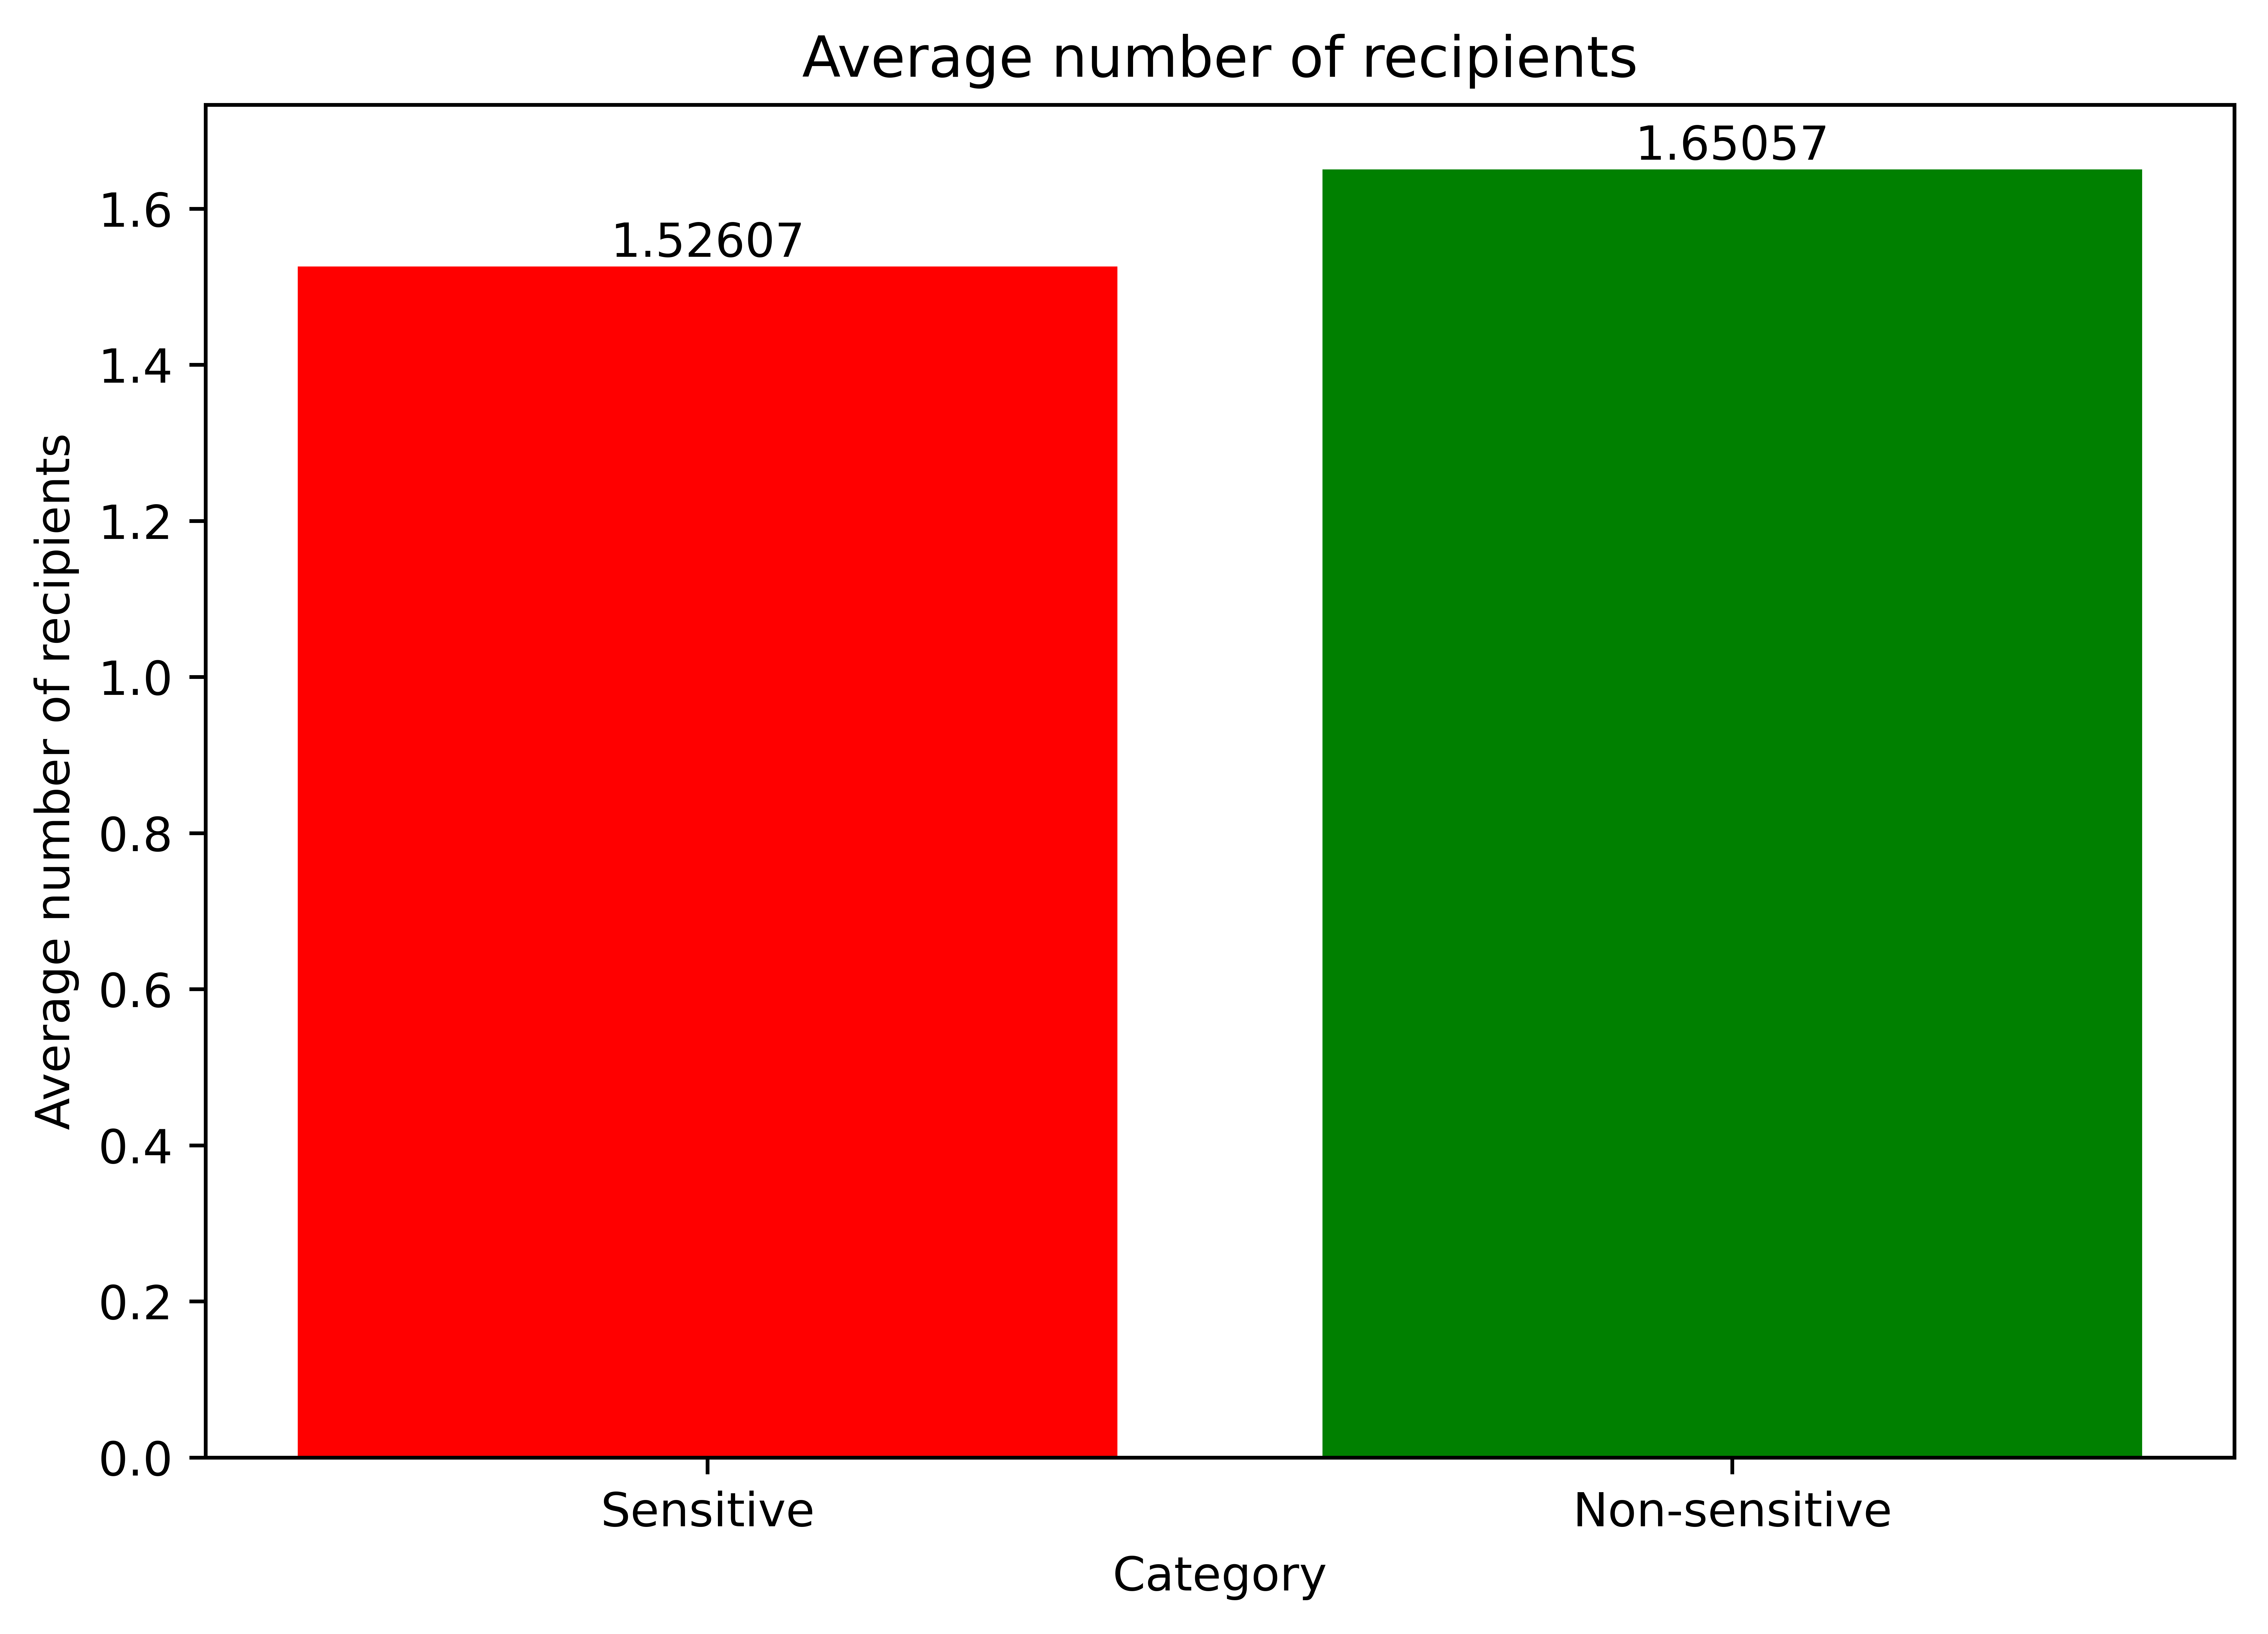

In [41]:
# Compare number of recipients 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["Sensitive", "Non-sensitive"]
data = [np.mean(sensitive_recipients), np.mean(non_sensitive_recipients)]
bars = ax.bar(labels,data, color = ["Red","Green"])
ax.set_title("Average number of recipients")
ax.set_xlabel("Category")
ax.set_ylabel("Average number of recipients")
ax.bar_label(bars)
fig.set_dpi(1080)
plt.savefig('number_of_recipients.png',bbox_inches='tight')

In [56]:
'''
{email_address: [#sensitive_emails, #non_sensitive_emails]}
'''

filenames = list_all_filenames()
senders = []
for name in filenames:
    senders.append(get_sender_from_filename(name))

senders_habits = dict()

for s in sensitive_filenames:
    sender = get_sender_from_filename(s)
    if sender in senders_habits:
        senders_habits[sender][0] += 1
    else:
        senders_habits[sender] = [1,0]
    
for s in non_sensitive_filenames:
    sender = get_sender_from_filename(s)
    if sender in senders_habits:
        senders_habits[sender][1] += 1
    else:
        senders_habits[sender] = [0,1]